# Surface Visualization Demo Notebook, Neurohackweek, 8 Sept 2017

- (Mostly) developted by Murat Bilgel, Benjamin Ely, Melanie Ganz, Krisanne Litinas, and Andrea Shafer
- Heavily indebted to Satra Ghosh, Chris Holdgraf, Anisha Keshavan, and Tal Yarkoni
- Builds on 
[IPyvolume](https://ipyvolume.readthedocs.io/en/latest/index.html), 
[NiBabel cifti2 package](http://nipy.org/nibabel/reference/nibabel.cifti2.html), 
[Michiel Cottaar's cifti tools](https://git.fmrib.ox.ac.uk/ndcn0236/cifti), and [various NHW demo notebooks](https://github.com/neurohackweek)


<b>Load packages etc:</b>

In [638]:
%matplotlib inline
import matplotlib.pyplot as plt
import nibabel as nb
import ipyvolume
import ipyvolume.pylab as p3
import numpy as np
import os, sys, time
import niwidgets
from niwidgets import NiftiWidget
from niwidgets import niwidget_surface
import nilearn.plotting as nip
from ipywidgets import interact, fixed, IntSlider, FloatSlider
from ipywidgets import interact,fixed,IntSlider
from nilearn import image
from itertools import islice

In [401]:
# NB: added 'export NHW=$HOME/Desktop/nhw2017/NHW_visualization' to ~/.bashrc
nhw = os.environ['NHW'] 
# FYI example data primarily from Human Connectome Project subject 100610
path_lh = nhw+'/data/100610/MNINonLinear/fsaverage_LR32k/100610.L.very_inflated_MSMAll.32k_fs_LR.surf.gii'
data_lh = nb.load(path_lh)
path_rh = nhw+'/data/100610/MNINonLinear/fsaverage_LR32k/100610.R.midthickness_MSMAll.32k_fs_LR.surf.gii'
data_rh = nb.load(path_rh)
path_sc=nhw+'/data/100610/MNINonLinear/ROIs/Atlas_ROIs.2.nii.gz'
data_sc = nb.load(path_sc)

path_lh_myelin = nhw+'/data/100610/MNINonLinear/fsaverage_LR32k/100610.L.MyelinMap.32k_fs_LR.func.gii'
data_lh_myelin = nb.load(path_lh_myelin)
path_rh_myelin = nhw+'/data/100610/MNINonLinear/fsaverage_LR32k/100610.R.MyelinMap.32k_fs_LR.func.gii'
data_rh_myelin = nb.load(path_rh_myelin)

path_lh_corthick = nhw+'/data/100610/MNINonLinear/fsaverage_LR32k/100610.L.corrThickness.32k_fs_LR.shape.gii'
data_lh_corthick = nb.load(path_lh_corthick)

filename = os.path.join(nhw,'data','subjA','subjA_t0_pet_mni.nii.gz')
filename_4D = os.path.join(nhw,'data','subjA','subjA_4D_pet_mni.nii.gz')

path_ciftiTS = nhw+'/data/100610/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii'
data_ciftiTS = nb.load(path_ciftiTS)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


<b>Surface display functions:</b>  

In [551]:
def showSurface(surface,overlay=None,frame=0,newfigure=True,colormap='summer',figsize=np.array([600,600]),
                figlims=np.array([[-100,100],[-100,100],[-100,100]]),showZeroes=True):
    '''
    Displays a surface mesh in gifti or FreeSurfer (FS) surface format with/without an overlay inside  
    Jupyter notebook for interactive visualization.

    Parameters
    ----------
    surface: str, gifti object
        Path to surface file in gifti or FS surface format or an already loaded gifti object of surface
    overlay: str, gifti object
        Path to overlay file in gifti or FS annot or anaotimcal (.curv,.sulc,.thickness) format or an already loaded 
        gifti object of overlay, default None
    frame: int
        index of the frame (timepoint or functional data frame) to show
    newfigure: bool
        Create a new figure else prints into the last figure (in order to visualize both hemispheres in 
        one plot), default True
    colormap: string
        A matplotlib colormap, default summer
    figsize: ndarray
        Size of the figure to display, default [600,600]
    figLims: ndarray
        x,y and z limits of the axes, default [[-100,100],[-100,100],[-100,100]])
    showZeroes: bool
        Display vertices with intensity = 0, default True

    '''

    if isinstance(surface,str):
        if not os.path.exists(surface):
            error('File does not exist, please provide a valid file path to a gifti or FreeSurfer file.')
        filename, file_extension = os.path.splitext(surface)
        if file_extension is '.gii':
            surface = nb.load(surface)
        else:
            fsgeometry = nb.freesurfer.read_geometry(surface)
            x,y,z = fsgeometry[0].T
            vertex_edges=fsgeometry[1]

    if isinstance(surface,nb.gifti.gifti.GiftiImage):
        try:
            vertex_spatial=surface.darrays[0]
            vertex_edges=surface.darrays[1]
            x, y, z = vertex_spatial.data.T
        except:
            raise ValueError('Please provide a valid gifti file.')

    
    if not isinstance(frame,int):
        raise ValueError('Please provide a valid integer frame index.')
    
    if isinstance(overlay,list):
        if frame>len(overlay) or frame < 0:
            error('Frame index out of bounds, please provide a valid frame index.')
        overlay = overlay[frame]
    
    if isinstance(overlay,str):
        if not os.path.exists(overlay):
            error('File does not exist, please provide a valid file path to a gifti or FreeSurfer file.')
        filename, file_extension = os.path.splitext(overlay)
        
        if file_extension is '.gii':
            overlay = nb.load(overlay)
        elif (file_extension in ('.annot','')):
            annot = nb.freesurfer.read_annot(overlay)
            activation = annot[0]
        elif (file_extension in ('.curv','.thickness','.sulc')):
            activation = nb.freesurfer.read_morph_data(overlay)
#        elif (file_extension in ('.dlabel.nii','.dscalar.nii','.dconn.nii','.dtseries.nii')):
#            left,right,sub=csplit(overlay)

            
    if isinstance(overlay,nb.gifti.gifti.GiftiImage):
        try:
            activation=overlay.darrays[0].data
        except:
            raise ValueError('Please provide a valid gifti file')
            
            
    
    if showZeroes is False:
        try:
            mkeep,mkill=zmask(surface,overlay)
        except:
            raise ValueError('Overlay required for medial wall masking.')
    
    
    if newfigure:

        fig = p3.figure(width=figsize[0], height=figsize[1])
        fig.camera_fov = 1
        fig.style = {'axes': {'color': 'black',
          'label': {'color': 'black'},
          'ticklabel': {'color': 'black'},
          'visible': False},
         'background-color': 'white',
         'box': {'visible': False}}
        fig.xlim = (figlims[0][0], figlims[0][1])
        fig.ylim = (figlims[1][0], figlims[1][1])
        fig.zlim = (figlims[2][0], figlims[2][1])

        
    # plot surface
    if overlay is None:
        p3.plot_trisurf(x, y, z, triangles=vertex_edges.data)
    elif showZeroes is False:
        my_color = plt.cm.get_cmap(colormap)
        colors=my_color(oscale(activation))
        p3.plot_trisurf(x, y, z, triangles=vertex_edges.data[mkeep], color=colors[:,:3])
    else:
        my_color = plt.cm.get_cmap(colormap)
        colors=my_color(oscale(activation))
        p3.plot_trisurf(x, y, z, triangles=vertex_edges.data, color=colors[:,:3])

    if newfigure:
        p3.show()
        
    return 1

In [402]:
def zmask(surf,mask):
    '''
    Masks out vertices with intensity=0 from overlay. Also returns masked-out vertices.
    
    Parameters
    ----------
    surf: gifti object
        already loaded gifti object of target surface
    mask: gifti object
        already loaded gifti object of overlay with zeroes at vertices of no interest (e.g. medial wall)
    '''
    keep=(mask.darrays[0].data!=0) # nonzero values of mask
    kill=(mask.darrays[0].data==0) # zero values of mask
    ikeep=[i for i, e in enumerate(keep) if e != 0] # indices of nonzero mask values
    ikill=[i for i, e in enumerate(kill) if e != 0] # indices of zero mask values
    killdict={ii:1 for ii in ikill} # fun fact, iterating over a dictionary is ~exponentially faster vs. over a list
    mask_kill=np.zeros([surf.darrays[1].data.shape[0]],dtype=bool) # create empty arrays matching surface mesh dimentions
    mask_keep=mask_kill.copy()
    for ii, row in enumerate(surf.darrays[1].data):
        for item in row:
            if item in killdict.keys():
                mask_kill[ii]=True
                continue
            else:
                mask_keep[ii]=True
                continue
    return mask_keep, mask_kill

In [404]:
def mwpad(overlay,template,frame=0):
    '''
    Adds intensity=0 vertices along medial wall of overlay

    Parameters
    ----------
    overlay: gifti object
        gifti object overlay to be padded (e.g. hemisphere data array from a cifti file)
    template: gifti object
        gifti object with zeroes at medial wall vertices, otherwise matched to overlay (e.g. myelin map)
    frame: int
        index of the timepoint to show, default 0, ignored if overlay only has one timepoint
    '''
    padolay=nb.gifti.gifti.GiftiImage()
    padded=np.zeros(template.darrays[0].data.shape[0])
    count=0        
    for i, x in enumerate(template.darrays[0].data):
        if x!=0:
            if overlay.darrays[0].data.ndim > 1:
                padded[i]=overlay.darrays[0].data[frame,count]
            else:
                padded[i]=overlay.darrays[0].data[count]
            count=count+1
    padarray=nb.gifti.gifti.GiftiDataArray(padded)
    padolay.add_gifti_data_array(padarray)
    return padolay

In [405]:
def oscale(overlay):
    '''
    Scales input array values to between zero and one, as needed for iPyVolume colormaps.
    For now, olay must be a 1D array (single timepoint).
    
    Parameters
    ----------
    overlay: gifti object
        gifti object overlay to be scaled (e.g. myelin map)
    '''
    scaled=np.asarray((overlay-min(overlay))/(max(overlay)-min(overlay)))
    return scaled

In [409]:
# showSurface example 1:
# right surface only
showSurface(data_rh)

A Jupyter Widget

1

In [410]:
# showSurface example 2:
# new plot, same surface but with myelin map overlay
fig=showSurface(data_rh,data_rh_myelin)

A Jupyter Widget

In [411]:
# same plot, added "very inflated" left surface, excluded medial wall
fig=showSurface(data_lh,data_lh_myelin,newfigure=False,showZeroes=False)

<b>NiWidgets 4D longitudinal or timeseries display:</b>

In [293]:
# 1) get the default plotter in niwidgets and manipulate it.
# 2) write function for an spaghetti plot showing the longitudinal trend at selected voxel

def plot_timepoint_slices(data, figure, x, y, z, t=0, colormap='viridis', figsize=(15, 5)):
    """
    Plots x,y,z slices at time point t.
    """
    
    coords = [x, y, z]
    views = ['Sagittal', 'Coronal', 'Axial']
    
    axes = [figure.add_subplot(231), figure.add_subplot(232), figure.add_subplot(233),
            figure.add_subplot(234)]
    
    
    data = data.dataobj.get_unscaled()
    print(data.shape)
    for subplot in range(3):
        slice_obj = 3 * [slice(None)] + [t]
        slice_obj[subplot] = coords[subplot]

        plt.sca(axes[subplot])
        axes[subplot].set_facecolor('black')
        axes[subplot].set_title(views[subplot])
        axes[subplot].tick_params(
            axis='both', which='both', bottom='off', top='off',
            labelbottom='off', right='off', left='off', labelleft='off'
            )
        # fix the axis limits
        axis_limits = [limit for i, limit in enumerate(data.shape)
                       if i != subplot]
        axes[subplot].set_xlim(0, axis_limits[0])
        axes[subplot].set_ylim(0, axis_limits[1])

        # plot the actual slice
        if subplot == 0:
            plt.imshow(np.flipud(np.rot90(data[slice_obj], k=1)),
                       cmap=colormap)
        else:
            plt.imshow(np.rot90(data[slice_obj], k=3), cmap=colormap)
        # draw guides to show where the other two slices are
        guide_positions = [val for i, val in enumerate(coords)
                           if i != subplot]
        plt.axvline(x=guide_positions[0], color='gray', alpha=0.8)
        plt.axhline(y=guide_positions[1], color='gray', alpha=0.8)

    #plt.sca(axes[-1])
    axes[-1].plot(range(data.shape[3]),data[x,y,z,:],'o-')
    axes[-1].plot(t,data[x,y,z,t],'ro')
    axes[-1].set_xlabel('Time point')
    axes[-1].set_ylabel('Intensity')
    
    # show the plot
    plt.show()
    # print the value at that point in case people need to know
    print('Value at point {x}, {y}, {z}, {t}: {intensity}'.format(
        x=x, y=y, z=z, t=t, intensity=data[x, y, z, t]
    ))

In [ ]:
# example volumetric 4D data:
my_4D_widget = NiftiWidget(filename_4D)
my_4D_widget.nifti_plotter(plotting_func=plot_timepoint_slices, 
                           x=IntSlider(90, min=0, max=181, continuous_update=False),
                           y=IntSlider(100, min=0, max=217),
                           z=IntSlider(90, min=0, max=181),
                           t=IntSlider(min=0, max=3))

In [ ]:
# example surface 4D data:
meshfile_lh_inflated = nhw+'/data/006/surf/lh.inflated'
overlayfiles_lh = [nhw+'/data/006/surf/lh.thickness',nhw+'/data/006/surf/lh.curv']
sw = niwidget_surface.SurfaceWidget(meshfile=meshfile_lh_inflated,
                                    overlayfiles = overlayfiles_lh)
sw.surface_plotter()
sw.fig

<b>CIFTI tools:</b>

In [421]:
def cread(infile):
    '''
    Loads a cifti file and stores as five objects: data array, cifti header, nifti header, extra metadata, filemap
    Example call:
        cd,ch,cn,cx,cf=cread(path_to_cifti)
    
    Parameters
    ----------
    infile: str, Cifti2Image
        string containing path to cifti file or an already loaded cifti object
    '''
    if isinstance(infile,nb.cifti2.cifti2.Cifti2Image):
        try:
            cin=infile
        except:
            raise ValueError('Please provide a valid cifti file.')
    elif isinstance(infile,str):
        if not os.path.exists(infile):
            raise ValueError('File does not exist, please provide a valid path to a cifti file.')
        try:
            cin=nb.load(infile) # NB causes apparently benign warning as of NiBabel version 2.2.0dev
        except:
            raise ValueError('Please provide a valid cifti file.')
    cdata=np.asarray(cin.get_data()).copy()
    chead=cin.header.copy()
    cnhdr=cin.nifti_header.copy()
    cxtra=cin.extra.copy()
    cfmap=cin.file_map.copy()
    return cdata,chead,cnhdr,cxtra,cfmap

In [416]:
# cread example 1:
cd,ch,cn,cx,cf=cread(path_ciftiTS)
print(cd.data.shape)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(1200, 91282)


In [493]:
# cread example 2:
cd,ch,cn,cx,cf=cread(data_ciftiTS)
print(cd.data.shape)

(1200, 91282)


In [426]:
def csave(filename,cdata,chead,cnhdr=None,cxtra=None,cfmap=None,returnImg=False):
    '''
    Saves a cifti image from a collection of cifti substructures to file.
    
    Parameters
    ----------
    filename: str
        string containing output file path
    cdata: numpy ndarray
        array containing data to be saved, can be 1D (single timepoint) or 2D (timeseries)
    chead: Cifti2Header
        cifti header data, generally extracted from a previously read cifti file
    cnhdr: Nifti2Header (optional)
        nifti header data, also generally extracted from a previously read cifti file
    cxtra: dict (optional)
        extra cifti metadata, generally empty
    cfmap: dict (optional)
        file map, generally contains the string 'image'
    returnImg: bool
        optionally return the compiled cifti object
    '''
    cout=nb.Cifti2Image(dataobj=cdata,header=chead,nifti_header=cnhdr, extra=cxtra, file_map=cfmap)
    cout.to_filename(filename)
    if returnImg is True:
        return cout

In [429]:
# csave example:
output_cifti=nhw+'/save_demo.dtseries.nii'
csave(output_cifti,cd,ch,cn,ch,cf)

In [437]:
def clthresh(data,thresh,setTo=0):
    '''
    Set all values below threshold for a cifti file to a given value (default 0).
    
    Parameters
    ----------
    data: numpy ndarray
        array containing data to be thresholded
    thresh: float
        Threshold value (exclusive)
    setTo: float
        Value to which voxels/vertices are set if below the threshold, default 0
    '''
    # 
    lthr_data=data.copy()
    lthr_data[lthr_data<thresh]=setTo
    return lthr_data

In [438]:
def cuthresh(data,thresh,setto=0):
    '''
    Set all values above threshold for a cifti file to a given value (default 0).
    
    Parameters
    ----------
    data: numpy ndarray
        array containing data to be thresholded
    thresh: float
        Threshold value (exclusive)
    setTo: float
        Value to which voxels/vertices are set if above the threshold, default 0
    '''
    # set all values above threshold to a given value (default 0)
    uthr_data=data.copy()
    uthr_data[uthr_data>thresh]=setto
    return uthr_data

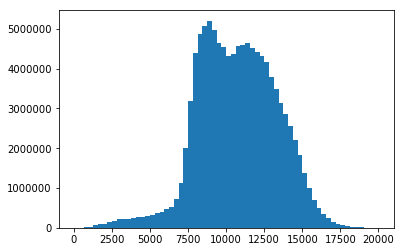

In [302]:
# clthresh/cuthresh example:
p1=plt.hist(cd[np.nonzero(cd)], 64,[0,20000])

In [434]:
tl12000_cd=clthresh(cd,12000)
tu12000_cd=cuthresh(cd,12000)
p1=plt.hist(tu12000_cd[np.nonzero(tu12000_cd)], 64, [0,20000],color='Orange')
p1=plt.hist(tl12000_cd[np.nonzero(tl12000_cd)], 64, [0,20000],color='Green')
output_cifti=nhw+'/thresh_demo.dtseries.nii'
csave(output_cifti,tl12000_cd,ch,cn,cx,cf)

In [457]:
def cmask(target,mask):
    '''
    Masks target cifti file with non-zero values of mask cifti file
    
    Parameters
    ----------
    target: numpy ndarray
        numpy array containing cifti data to be masked
    mask: numpy ndarray
        numpy array containing cifti data to use as mask. Can be 1D or 2D, must match target spatial dimensions.
    '''
    masked_data=target.copy()
    if target.shape != mask.shape:
        mask=np.tile(mask,(target.shape[0],1))
    masked_data[mask==0]=0 # NB could be sped up by using a data dictionary, not currently high-priority
    return masked_data

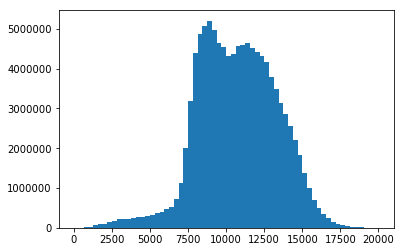

In [305]:
# cmask example:
plt.hist(cd[np.nonzero(cd)],64,[0,20000]);

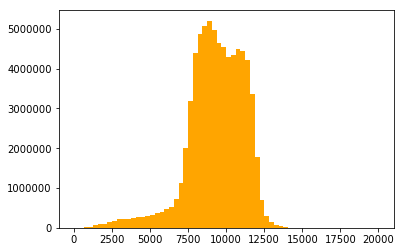

In [464]:
masked3d=cmask(cd,tu12000_cd[0]) # masking 4d timeseries with single 3d timepoint
plt.hist(masked3d[np.nonzero(masked3d)],64,[0,20000],color='Orange');

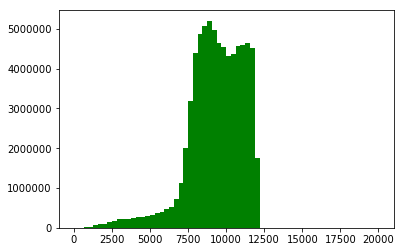

In [463]:
masked4d=cmask(cd,tu12000_cd)    # masking 4d timeseries with 4d timeseries
plt.hist(masked4d[np.nonzero(masked4d)],64,[0,20000],color='Green');

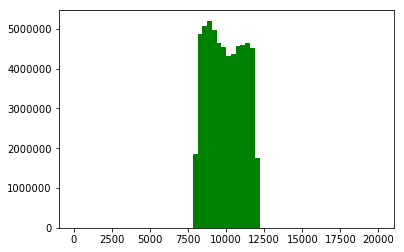

In [308]:
tl8000_cd=clthresh(cd,8000)
range4d=cmask(tl8000_cd,tu12000_cd)    # masking 4d timeseries with 4d timeseries
plt.hist(range4d[np.nonzero(range4d)],64,[0,20000],color='Green');
output_cifti=nhw+'/range_demo.dtseries.nii'
csave(output_cifti,range4d,ch,cn,ch,cf)

In [629]:
def cinfo(infile):
    '''
    Returns information about input cifti header
    
    Parameters
    ----------
    infile: str, Cifti2Image
        string containing path to cifti file or an already loaded cifti object
    verbose: bool
        report relatively esoteric cifti header info
    '''
    if isinstance(infile,nb.cifti2.cifti2.Cifti2Header):
        ch=infile
    elif isinstance(infile,nb.cifti2.cifti2.Cifti2Image):
        cin=infile
        cd,ch,cn,cx,cf=cread(infile)
    elif isinstance(infile,str):
        if not os.path.exists(infile):
            raise ValueError('File does not exist, please provide a valid path to a cifti file.')
        try:
            cd,ch,cn,cx,cf=cread(infile)
        except:
            raise ValueError('Please provide a valid cifti file.')
    ch0=ch.get_index_map(0)
    ch1=ch.get_index_map(1)
    if ch.get_index_map(0).indices_map_to_data_type=='CIFTI_INDEX_TYPE_SERIES': # support for other cifti types pending
        print('cifti data dype = fMRI timeseries')
        me=ch1.volume.transformation_matrix_voxel_indices_ijk_to_xyz.meter_exponent
        if me==-3:
            units='MM'
        else:
            units='x10^{e} M'.format(e=me)
        print('Xdim = {x} {u} x {xx}'.format(
            x=np.abs(ch1.volume.transformation_matrix_voxel_indices_ijk_to_xyz.matrix[0,0]),
            u=units,
            xx=ch1.volume.volume_dimensions[0]))
        print('Ydim = {y} {u} x {yy}'.format(
            y=np.abs(ch1.volume.transformation_matrix_voxel_indices_ijk_to_xyz.matrix[1,1]),
            u=units,
            yy=ch1.volume.volume_dimensions[1]))
        print('Zdim = {z} {u} x {zz}'.format(
            z=np.abs(ch1.volume.transformation_matrix_voxel_indices_ijk_to_xyz.matrix[2,2]),
            u=units,
            zz=ch1.volume.volume_dimensions[2]))
        print('Tdim = {y} {z} x {t}'.format(
            y=ch.get_index_map(0).series_step,
            z=ch.get_index_map(0).series_unit,
            t=ch.get_index_map(0).number_of_series_points))
    disp=[]
    voxels=0
    print('INDEX      OFFSET     SIZE       STRUCTURE')
    for idx, bm in enumerate(ch1.brain_models):
        disp.append([idx,bm.index_offset,bm.index_count,bm.brain_structure])
        if bm.model_type=='CIFTI_MODEL_TYPE_VOXELS':
            voxels=voxels+bm.index_count
    col_width = max(len(str(word)) for row in disp for word in row) + 2  # padding
    for row in disp:
        print("{: <10} {: <10} {: <10} {: <20}".format(*row))
    print('total left cortex vertices = {lv} of {lt}'.format(
        lv=list(ch1.brain_models)[0].index_count,
        lt=list(ch1.brain_models)[0].surface_number_of_vertices))
    print('total right cortex vertices = {rv} of {rt}'.format(
        rv=list(ch1.brain_models)[1].index_count,
        rt=list(ch1.brain_models)[1].surface_number_of_vertices))
    print('total subcortical voxels = {v}'.format(v=voxels))
    print('total data points = {total}'.format(
        total=list(ch1.brain_models)[0].index_count+list(ch1.brain_models)[1].index_count+voxels))

In [630]:
# cinfo examples:
print(cinfo(path_ciftiTS))
#print(cinfo(data_ciftiTS))
#print(cinfo(ch))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


cifti data dype = fMRI timeseries
Xdim = 2.0 MM x 91
Ydim = 2.0 MM x 109
Zdim = 2.0 MM x 91
Tdim = 0.72 SECOND x 1200
INDEX      OFFSET     SIZE       STRUCTURE
0          0          29696      CIFTI_STRUCTURE_CORTEX_LEFT
1          29696      29716      CIFTI_STRUCTURE_CORTEX_RIGHT
2          59412      135        CIFTI_STRUCTURE_ACCUMBENS_LEFT
3          59547      140        CIFTI_STRUCTURE_ACCUMBENS_RIGHT
4          59687      315        CIFTI_STRUCTURE_AMYGDALA_LEFT
5          60002      332        CIFTI_STRUCTURE_AMYGDALA_RIGHT
6          60334      3472       CIFTI_STRUCTURE_BRAIN_STEM
7          63806      728        CIFTI_STRUCTURE_CAUDATE_LEFT
8          64534      755        CIFTI_STRUCTURE_CAUDATE_RIGHT
9          65289      8709       CIFTI_STRUCTURE_CEREBELLUM_LEFT
10         73998      9144       CIFTI_STRUCTURE_CEREBELLUM_RIGHT
11         83142      706        CIFTI_STRUCTURE_DIENCEPHALON_VENTRAL_LEFT
12         83848      712        CIFTI_STRUCTURE_DIENCEPHALON_VENTRAL

In [552]:
def cvoxels(header,MNI=True,trim=False):
    '''
    Returns array where each element is an array of coordinates for a particular cifti brain structure.
    Coordinates can be voxel indices (i,j,k) or MNI coordinates (x,y,z; default).
    
    Parameters
    ----------
    header: Cifti2Header
        cifti header object containing the voxel index mapping and list of brain structures
    MNI: bool
        True returns MNI coordinates, False returns voxel indices, default=True
    trim: bool
        removes array elements corresponding to cortical surfaces, default=False
    '''
    if not isinstance(header,nb.cifti2.cifti2.Cifti2Header):
        raise ValueError('Please provide a valid cifti header.')

    ch1=header.get_index_map(1)
    voxarray=[]
    if MNI is True:
        from nibabel.affines import apply_affine
        warp=ch1.volume.transformation_matrix_voxel_indices_ijk_to_xyz.matrix
    for idx, bm in enumerate(ch1.brain_models):
        if bm.model_type=='CIFTI_MODEL_TYPE_VOXELS':
            if MNI is False:
                voxarray.append(np.asarray(bm.voxel_indices_ijk))
            else:
                voxarray.append(apply_affine(warp,bm.voxel_indices_ijk))
        else:
            if trim is False:
                voxarray.append([[],[],[]])
    return np.asarray(voxarray)

In [562]:
# cvoxels example:
for i in range(0,len(cvoxels(ch,MNI=False,trim=True)[0])):
    print(cvoxels(ch,MNI=False,trim=True)[0][i], cvoxels(ch,MNI=True,trim=True)[0][i])

[49 66 28] [ -8.   6. -16.]
[50 66 28] [-10.   6. -16.]
[48 67 28] [ -6.   8. -16.]
[49 67 28] [ -8.   8. -16.]
[50 67 28] [-10.   8. -16.]
[48 65 29] [ -6.   4. -14.]
[49 65 29] [ -8.   4. -14.]
[50 65 29] [-10.   4. -14.]
[48 66 29] [ -6.   6. -14.]
[49 66 29] [ -8.   6. -14.]
[50 66 29] [-10.   6. -14.]
[48 67 29] [ -6.   8. -14.]
[49 67 29] [ -8.   8. -14.]
[50 67 29] [-10.   8. -14.]
[50 64 30] [-10.   2. -12.]
[47 65 30] [ -4.   4. -12.]
[48 65 30] [ -6.   4. -12.]
[49 65 30] [ -8.   4. -12.]
[50 65 30] [-10.   4. -12.]
[47 66 30] [ -4.   6. -12.]
[48 66 30] [ -6.   6. -12.]
[49 66 30] [ -8.   6. -12.]
[50 66 30] [-10.   6. -12.]
[47 67 30] [ -4.   8. -12.]
[48 67 30] [ -6.   8. -12.]
[49 67 30] [ -8.   8. -12.]
[50 67 30] [-10.   8. -12.]
[48 68 30] [ -6.  10. -12.]
[49 68 30] [ -8.  10. -12.]
[50 68 30] [-10.  10. -12.]
[51 68 30] [-12.  10. -12.]
[50 69 30] [-10.  12. -12.]
[51 69 30] [-12.  12. -12.]
[47 65 31] [ -4.   4. -10.]
[48 65 31] [ -6.   4. -10.]
[49 65 31] [ -8.   4

In [633]:
def csplit(incifti,gii=False):
    '''
    Split cifti overlay into separate left surface, right surface, and subcortical voxel arrays.
    
    Parameters
    ----------
    incifti: str, Cifti2Image
        string containing path to cifti file or an already loaded cifti object
    gii: bool
        returns surfaces as GiftiImage objects, default=False
    '''
    if isinstance(incifti,nb.cifti2.cifti2.Cifti2Image):
        cd=np.asarray(incifti.get_data()).copy()
        ch=incifti.header.copy()
    elif isinstance(incifti,str):
        if not os.path.exists(incifti):
            raise ValueError('File does not exist, please provide a valid path to a cifti file.')
        try:
            cd,ch,cn,cx,cf=cread(incifti)
        except:
            raise ValueError('Please provide a valid cifti file.')   
    mim = ch.matrix[1]
    bm1 = list(mim.brain_models)[0]
    bm2 = list(mim.brain_models)[1]
    lidx = list(bm1.vertex_indices)
    ridx = [bm1.surface_number_of_vertices + val for val in bm2.vertex_indices]
    bidx = np.concatenate((lidx, ridx))
    # split cifti overlay into left surface, right surface, and subcortical volume
    clh=cd[:,0:len(lidx)]
    crh=cd[:,len(lidx):len(lidx)+len(ridx)+1]
    csc=cd[:,len(lidx)+len(ridx)+1:cd.shape[1]]
    if gii is True:
        glh=nb.gifti.gifti.GiftiImage()
        grh=nb.gifti.gifti.GiftiImage()
        glh.add_gifti_data_array(nb.gifti.gifti.GiftiDataArray(clh))
        grh.add_gifti_data_array(nb.gifti.gifti.GiftiDataArray(crh))
        left=glh
        right=grh
    else:
        left=clh
        right=crh
    sub=csc # option for .nii format subcortex data pending
    return left, right, sub

In [649]:
# csplit example 1:
a,b,c=csplit(data_ciftiTS,gii=True)
aa=mwpad(a,data_lh_myelin,frame=0)
bb=mwpad(b,data_rh_myelin,frame=0)
fig2=showSurface(data_lh,aa,showZeroes=False)
fig2=showSurface(data_rh,bb,showZeroes=False,newfigure=False)

A Jupyter Widget

In [650]:
# csplit example 2:
aaa=mwpad(a,data_lh_myelin,frame=0)
fig3=showSurface(data_lh,aaa,showZeroes=False)
for x in range(1,10):
    time.sleep(1)
    aaa=mwpad(a,data_lh_myelin,frame=x)
    fig3=showSurface(data_lh,aaa,showZeroes=False,newfigure=False)

A Jupyter Widget

In [651]:
# csplit example 2:
thrl,thrr,thrs=csplit(nhw+'/thresh_demo.dtseries.nii',gii=True)
aaa=mwpad(thrl,data_lh_myelin,frame=0)
fig4=showSurface(data_lh,aaa,showZeroes=False)
for x in range(1,10):
    time.sleep(1)
    aaa=mwpad(thrl,data_lh_myelin,frame=x)
    fig4=showSurface(data_lh,aaa,showZeroes=False,newfigure=False)

A Jupyter Widget

In [637]:
d=nb.cifti2.cifti2.Cifti2Image(dataobj=range4d, header=ch, nifti_header=cn, extra=cx, file_map=cf)
dl,dr,ds=csplit(d,gii=True)
ddl=mwpad(dl,data_lh_myelin)
fig4=showSurface(data_lh,aa,showZeroes=False)
time.sleep(5)
fig4=showSurface(data_lh,ddl,showZeroes=False,newfigure=False,colormap='autumn')

A Jupyter Widget

Other stuff still in development:

In [314]:
def cplot(coverlay,lsurf,rsurf,subvol,colormap):
    # plots cifti overlay data with specified color on surfaces/subcortex
    # lsurf and rsurf should be .surf.gii files matched to the number of vertices in each cifti hemisphere
    # subvol should be a HCP-style subcortical volume (e.g. Atlas_ROIs.2.nii.gz)
    
    # import packages
    import nibabel as nb
    import matplotlib.pyplot as plt
    import ipyvolume
    import ipyvolume.pylab as p3
    import numpy as np
    
    # read input files
    ls=nb.load(lsurf)
    rs=nb.load(rsurf)
    sv=nb.load(subvol)
    
    # parse surface structure
    lxyz=ls.darrays[0]
    rxyz=rs.darrays[0]
    lmesh=ls.darrays[1]
    rmesh=rs.darrays[1]
    
    # plot
    showSurface(lsurf,coverlay,showZeroes=False)
    
#    return 1
    

In [ ]:
%whos

In [658]:
    # WARNING: still in development
    if isinstance(overlay,nb.cifti2.cifti2.Cifti2Image):
        try:
            left,right,sub=csplit(overlay)
            activation=left[0]
        except:
            raise ValueError('Please provide a valid cifti file.')

NameError: name 'overlay' is not defined

In [663]:
reset_selective cplt

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [664]:
import ciftitools as ct
import ciftiplot as cplt

cplt.showSurface(data_lh,data_lh_myelin)

NameError: name 'p3' is not defined